In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure
from utils import data_util

In [2]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import time
#%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LassoCV,LassoLarsCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from time import time

R2 = make_scorer(r2_score, greater_is_better=True)

In [3]:
print 'load datas...'
train, test = data_util.load_dataset()

y_train_all = train['y']
del train['ID']
del train['y']
id_test = test['ID']
del test['ID']

load datas...


In [4]:
X_train = train
X_test = test
y_train = y_train_all
y_mean = np.mean(y_train)
del train, test, y_train_all

In [5]:
X_train.shape, y_train.shape

((4209, 572), (4209,))

In [6]:
def DeepCV(train, y_train_all, model, n_folds=10): 
    train_r2_scores = []
    val_r2_scores = []
    num_boost_roundses = []
    df_columns = train.columns.values
    for i in range(0, n_folds):
        random_state = 42 + i
        X_train, X_val, y_train, y_val = train_test_split(train, y_train_all, test_size=0.25, random_state=random_state)

        dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
        dval = xgb.DMatrix(X_val, y_val, feature_names=df_columns)

        y_mean = np.mean(y_train)

        cv_result = xgb.cv(dict(xgb_params, base_score=y_mean),  # base prediction = mean(target)
                           dtrain,
                           num_boost_round=2000,  # increase to have better results (~700)
                           early_stopping_rounds=50,
                           )

        num_boost_rounds = len(cv_result)
        num_boost_roundses.append(num_boost_rounds)
        model = xgb.train(dict(xgb_params, base_score=y_mean), dtrain, num_boost_round=num_boost_rounds)
        train_r2_score = r2_score(dtrain.get_label(), model.predict(dtrain))
        val_r2_score = r2_score(dval.get_label(), model.predict(dval))
        print 'perform {} cross-validate: train r2 score = {}, validate r2 score = {}'.format(i + 1, train_r2_score,
                                                                                              val_r2_score)
        train_r2_scores.append(train_r2_score)
        val_r2_scores.append(val_r2_score)

    print '\naverage train r2 score = {}, average validate r2 score = {}'.format(
        sum(train_r2_scores) / len(train_r2_scores),
        sum(val_r2_scores) / len(val_r2_scores))

    
def PrintImportance(X_train, y_train, model):
    model.fit(X_train, y_train)
    feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)[:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.figure(figsize=(50,50))

In [7]:
def CV(train, y, model, test_size=.2, CV_metric=r2_score):
    X_train, X_val, y_train, y_val=train_test_split(train, y, test_size=test_size, 
                                                random_state=123)

    model.fit(X_train, y_train)
    
    train_score = CV_metric(y_train, model.predict(X_train))
    val_score = CV_metric(y_val, model.predict(X_val))
    print 'train_score =', train_score, ', val_score =', val_score

[0]	train-rmse:99.9663	test-rmse:99.9651
[50]	train-rmse:60.8932	test-rmse:60.8895
[100]	train-rmse:37.4672	test-rmse:37.4675
[150]	train-rmse:23.6347	test-rmse:23.646
[200]	train-rmse:15.7571	test-rmse:15.7867
[250]	train-rmse:11.566	test-rmse:11.6365
[300]	train-rmse:9.53984	test-rmse:9.66741
[350]	train-rmse:8.63971	test-rmse:8.82708
[400]	train-rmse:8.24606	test-rmse:8.49418
[450]	train-rmse:8.05973	test-rmse:8.36746
[500]	train-rmse:7.95839	test-rmse:8.31908
[550]	train-rmse:7.88687	test-rmse:8.30355
[600]	train-rmse:7.83075	test-rmse:8.30061


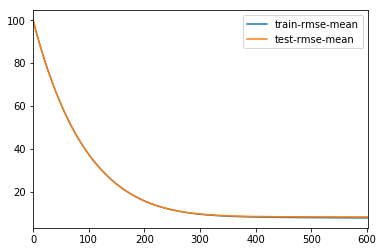

In [9]:
# xgb_params = {
#     'eta': .1,
#     'max_depth': 5,
#     'subsample': 0.8,
#     'reg_alpha': 0,
#     'min_child_weight':1,
#     'colsample_bytree': 0.8,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1,
#     'booster' :'gbtree',
#     'tuneLength': 3,
#     'seed': 123
# }


xgb_params = {
    'eta': .01,
    'max_depth': 2,
    'subsample': 0.9,
    'reg_alpha': 0,
    'min_child_weight':4,
    'colsample_bytree': 0.75,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,\
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
#.02 test-rmse:8.32887
#.01 test-rmse:8.31722

In [10]:
DeepCV(X_train, y_train, xgb_params, n_folds=5)

perform 1 cross-validate: train r2 score = 0.600473511483, validate r2 score = 0.580341942087
perform 2 cross-validate: train r2 score = 0.595885655081, validate r2 score = 0.569933943221
perform 3 cross-validate: train r2 score = 0.611621527488, validate r2 score = 0.55163848805
perform 4 cross-validate: train r2 score = 0.581344587375, validate r2 score = 0.614555116036
perform 5 cross-validate: train r2 score = 0.638767241862, validate r2 score = 0.490227437322

average train r2 score = 0.605618504658, average validate r2 score = 0.561339385343


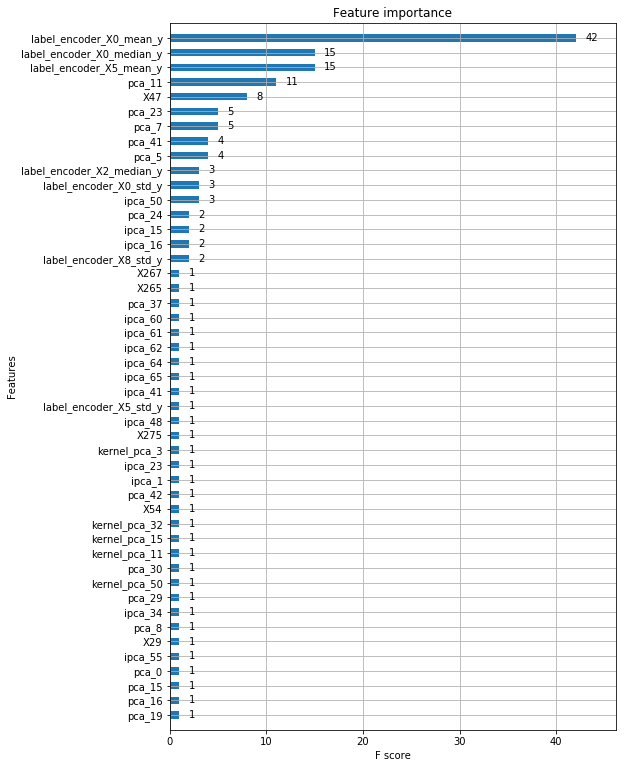

In [33]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [13]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=5, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'max_depth': np.arange(3,10,2),
       'min_child_weight': np.arange(1,6,2),
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57018, std: 0.07221, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.57175, std: 0.07315, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.57019, std: 0.07251, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.56207, std: 0.07219, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 1}, mean: 0.56162, std: 0.06974, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 3}, mean: 0.56523, std: 0.06987, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 5}, mean: 0.55360, std: 0.07174, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 1}, mean: 0.54872, std: 0.06602, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 3}, mean: 0.55676, std: 0.07375, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.54237, std: 0.07121, params: {'seed': 123, 'max_depth': 9, 'min_child_weight': 1}, mean: 0.53910, std: 0.06487, params

In [14]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=5, gamma=0, 
                          base_score=y_mean,
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1,)
param_grid = {
       'max_depth': [2,3,4],
       'min_child_weight': [2,3,4],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)

print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57114, std: 0.06494, params: {'seed': 123, 'max_depth': 2, 'min_child_weight': 2}, mean: 0.57178, std: 0.06733, params: {'seed': 123, 'max_depth': 2, 'min_child_weight': 3}, mean: 0.57297, std: 0.06816, params: {'seed': 123, 'max_depth': 2, 'min_child_weight': 4}, mean: 0.56329, std: 0.06427, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 2}, mean: 0.56580, std: 0.06636, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.56832, std: 0.06714, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 4}, mean: 0.55637, std: 0.06562, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 2}, mean: 0.55937, std: 0.06472, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 3}, mean: 0.56168, std: 0.06611, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 4}], {'seed': 123, 'max_depth': 2, 'min_child_weight': 4})
Best CV Score:
0.572972176324
0.8865260005


In [16]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=2, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'gamma' : [i/10.0 for i in np.arange(0,5)],
       'max_depth': [2],
       'min_child_weight': [4],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57441, std: 0.07137, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 4}, mean: 0.57441, std: 0.07137, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.10000000000000001, 'min_child_weight': 4}, mean: 0.57441, std: 0.07137, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.20000000000000001, 'min_child_weight': 4}, mean: 0.57441, std: 0.07137, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.29999999999999999, 'min_child_weight': 4}, mean: 0.57441, std: 0.07137, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.40000000000000002, 'min_child_weight': 4}], {'seed': 123, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 4})
Best CV Score:
0.574414694953
0.385008001328


In [17]:
DeepCV(model=model, train=X_train, y_train_all=y_train)

perform 1 cross-validate: train r2 score = 0.574948011821, validate r2 score = 0.56186387621
perform 2 cross-validate: train r2 score = 0.585140346954, validate r2 score = 0.563732639567
perform 3 cross-validate: train r2 score = 0.59439467836, validate r2 score = 0.538809361133
perform 4 cross-validate: train r2 score = 0.570955348933, validate r2 score = 0.613494574308
perform 5 cross-validate: train r2 score = 0.609948326161, validate r2 score = 0.474032762782
perform 6 cross-validate: train r2 score = 0.569348086647, validate r2 score = 0.606209870298
perform 7 cross-validate: train r2 score = 0.578582756031, validate r2 score = 0.626819707842
perform 8 cross-validate: train r2 score = 0.572044736346, validate r2 score = 0.597554980822
perform 9 cross-validate: train r2 score = 0.579861639814, validate r2 score = 0.579790362969
perform 10 cross-validate: train r2 score = 0.610878229139, validate r2 score = 0.497748812526

average train r2 score = 0.584610216021, average validate r2

In [18]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=2, gamma=0, \
                          min_child_weight=4, seed=123, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/10.0 for i in np.arange(6,10)],
    'colsample_bytree':[i/10.0 for i in np.arange(6,10)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.56798, std: 0.06851, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.59999999999999998}, mean: 0.57237, std: 0.07130, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.59999999999999998}, mean: 0.57239, std: 0.07177, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.59999999999999998}, mean: 0.57421, std: 0.07160, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.59999999999999998}, mean: 0.56970, std: 0.06945, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.69999999999999996}, mean: 0.57171, std: 0.07055, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.69999999999999996}, mean: 0.57318, std: 0.07210, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.69999999999999996}, mean: 0.57489, std: 0.07209, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.69999999999999996}, mean: 0.56890, std: 0.07015, para

In [20]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=2, gamma=0, \
                          min_child_weight=6, seed=123, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/100.0 for i in np.arange(85,100,5)],
    'colsample_bytree':[i/100.0 for i in np.arange(65,80,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57530, std: 0.07390, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.65000000000000002}, mean: 0.57410, std: 0.07275, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.65000000000000002}, mean: 0.57532, std: 0.07313, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.65000000000000002}, mean: 0.57552, std: 0.07347, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.69999999999999996}, mean: 0.57493, std: 0.07336, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.69999999999999996}, mean: 0.57559, std: 0.07302, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.69999999999999996}, mean: 0.57530, std: 0.07408, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.75}, mean: 0.57564, std: 0.07280, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.75}, mean: 0.57504, std: 0.07348, params: {'subsample': 0.9499999999

In [21]:
DeepCV(X_train, y_train, model)

perform 1 cross-validate: train r2 score = 0.574948011821, validate r2 score = 0.56186387621
perform 2 cross-validate: train r2 score = 0.585140346954, validate r2 score = 0.563732639567
perform 3 cross-validate: train r2 score = 0.59439467836, validate r2 score = 0.538809361133
perform 4 cross-validate: train r2 score = 0.570955348933, validate r2 score = 0.613494574308
perform 5 cross-validate: train r2 score = 0.609948326161, validate r2 score = 0.474032762782
perform 6 cross-validate: train r2 score = 0.569348086647, validate r2 score = 0.606209870298
perform 7 cross-validate: train r2 score = 0.578582756031, validate r2 score = 0.626819707842
perform 8 cross-validate: train r2 score = 0.572044736346, validate r2 score = 0.597554980822
perform 9 cross-validate: train r2 score = 0.579861639814, validate r2 score = 0.579790362969
perform 10 cross-validate: train r2 score = 0.610878229139, validate r2 score = 0.497748812526

average train r2 score = 0.584610216021, average validate r2

In [18]:
#del xgbreg
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.01, n_estimators=650, max_depth=2, gamma=0, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.9, colsample_bytree=.75,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[.1, 1, 10]#[1e4,1e5,1e6,1e7]#
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57456, std: 0.06910, params: {'reg_alpha': 0.1}, mean: 0.57456, std: 0.06914, params: {'reg_alpha': 1}, mean: 0.57567, std: 0.07007, params: {'reg_alpha': 10}], {'reg_alpha': 10})
Best CV Score:
0.575674898181
3.01882088184


In [22]:
#del xgbreg
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.01, n_estimators=650, max_depth=2, gamma=0, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.9, colsample_bytree=.75,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[5, 15, 50, 100]#[1e4,1e5,1e6,1e7]#
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

# ([mean: 0.57509, std: 0.06946, params: {'reg_alpha': 5}, mean: 0.57593, std: 0.07037, params: {'reg_alpha': 15}, mean: 0.57813, std: 0.07230, params: {'reg_alpha': 50}], {'reg_alpha': 50})
# Best CV Score:
# 0.578129274507
# 3.1214874506

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57509, std: 0.06946, params: {'reg_alpha': 5}, mean: 0.57593, std: 0.07037, params: {'reg_alpha': 15}, mean: 0.57813, std: 0.07230, params: {'reg_alpha': 50}, mean: 0.57789, std: 0.07336, params: {'reg_alpha': 100}], {'reg_alpha': 50})
Best CV Score:
0.578129274507
4.07781036695


In [23]:
#CV(model=xgbreg, train=X_train, y=y_train)
DeepCV(X_train, y_train, model)



perform 1 cross-validate: train r2 score = 0.600867365346, validate r2 score = 0.579350248265
perform 2 cross-validate: train r2 score = 0.604209381341, validate r2 score = 0.569639907346
perform 3 cross-validate: train r2 score = 0.612207311239, validate r2 score = 0.549827616538
perform 4 cross-validate: train r2 score = 0.579984500727, validate r2 score = 0.610814213116
perform 5 cross-validate: train r2 score = 0.637725194348, validate r2 score = 0.488420464654
perform 6 cross-validate: train r2 score = 0.586549410254, validate r2 score = 0.624212675966
perform 7 cross-validate: train r2 score = 0.584440583376, validate r2 score = 0.634286822738
perform 8 cross-validate: train r2 score = 0.588787179271, validate r2 score = 0.598597564753
perform 9 cross-validate: train r2 score = 0.602230373987, validate r2 score = 0.58824639975
perform 10 cross-validate: train r2 score = 0.627572118827, validate r2 score = 0.50054043945

average train r2 score = 0.602457341872, average validate r2

[0]	train-rmse:99.9671	test-rmse:99.9659
[50]	train-rmse:60.9255	test-rmse:60.9252
[100]	train-rmse:37.5192	test-rmse:37.5221
[150]	train-rmse:23.6978	test-rmse:23.7064
[200]	train-rmse:15.8334	test-rmse:15.8512
[250]	train-rmse:11.6584	test-rmse:11.6974
[300]	train-rmse:9.64391	test-rmse:9.72065
[350]	train-rmse:8.75077	test-rmse:8.8685
[400]	train-rmse:8.36021	test-rmse:8.52256
[450]	train-rmse:8.17511	test-rmse:8.38676
[500]	train-rmse:8.0711	test-rmse:8.33698
[550]	train-rmse:7.99969	test-rmse:8.31777
[600]	train-rmse:7.94676	test-rmse:8.31145


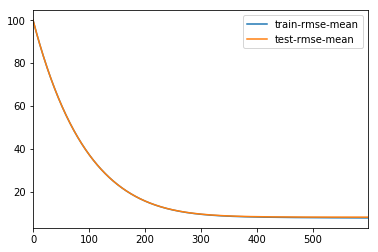

In [24]:
xgb_params = {
    'eta': .01,
    'max_depth': 2,
    'subsample': 0.9,
    'reg_alpha': 50,
    'min_child_weight':4,
    'colsample_bytree': 0.75,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,\
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
#.02 test-rmse:8.32887
#.01 test-rmse:8.31722

In [25]:
# xgb_params = {
#     'eta': .01,
#     'max_depth': 2,
#     'subsample': 0.7,
#     'reg_alpha': 0,
#     'min_child_weight':4,
#     'colsample_bytree': 0.75,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1,
#     'booster' :'gbtree',
#     'tuneLength': 3,
#     'seed': 123
# }

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
#y_predict = np.exp(y_predict)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'ID': id_test, 'y': y_predict})



In [76]:
xgb_params = {
    'eta': .02,#0.02,
    'max_depth': 6,
    'subsample': 0.95,
    'reg_alpha': 1e7,
    'min_child_weight':3,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 5
}

dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors])

num_boost_rounds = 250#len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



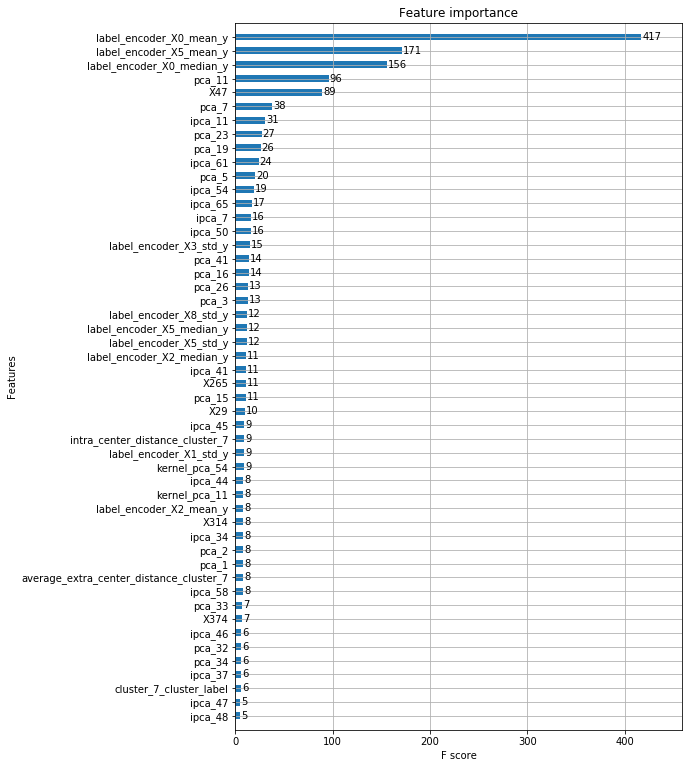

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [27]:
 output.to_csv('../result/jul6_1.csv', index=False)